# 08.06 Evaluate Clusters

One detail we left until about unsupervised learning is the evaluation
of the model performance.
In general evaluating unsupervised learning is much harder than
supervised learning because we cannot simply take the labels
and perform cross validation or use a test set.
That being said, most evaluations for unsupervised learning
do require labels to be known but cross validation or
test sets often do not make sense in these evaluations.

![Handwritten](ul-write.svg)

<div style="text-align:right;"><sup>ul-write.svg</sup></div>

We did see that the dataset of handwritten digits has non-linear patterns,
hence it is quite a difficult problem for a technique that is linear.
On the other hand, the digits dataset has a very known number of clusters:
exactly $10$ clusters, the digits from $0$ to $9$.

Hence we import the dataset loader and `MiniBatchKMeans`,
a k-means implementation that is the de-facto standard for k-means use.
Compared to our earlier implementation `MiniBatchKMeans` is optimized
to work with enormous amounts of data,
even with more data than the computer memory can hold.
We also import the `metrics` module which we will use to evaluate
the performance of our algorithm.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import load_digits

Without knowing of any labels k-means can deal with quite complex problems.
Note that we known the labels for the digits dataset
and we will indeed use the labels later for the evaluation.
But we will not tell k-means about the labels.

In [2]:
digits = load_digits()
digits.data.shape

(1797, 64)

One of the hyperparameters to `MiniBatchKMeans` is the number of clusters,
which for the digits is easy to know.

Let's see what k-means can take out of that data.

In [3]:
kmeans = MiniBatchKMeans(n_clusters=10)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

We used `fit_predict`, which is similar to `fit_transform`.
We have build the model (the `fit` part) and predicted the classes based
on the cluster centers built by this model.
Contrary to supervised learning,
it is common to predict on the same data in unsupervised learning.
This is because this way we can evaluate the model against other measures on the same data.
It is worth to repeat this,
in supervised learning predicting (and scoring) the same data that was used
for training/fitting is *very* bad practice;
in unsupervised learning it is *common* and good practice.

The cluster centers are shaped just like the images we worked with.
Since we are clustering in the same number of dimensions as the images.
And we can build images from the cluster centers.

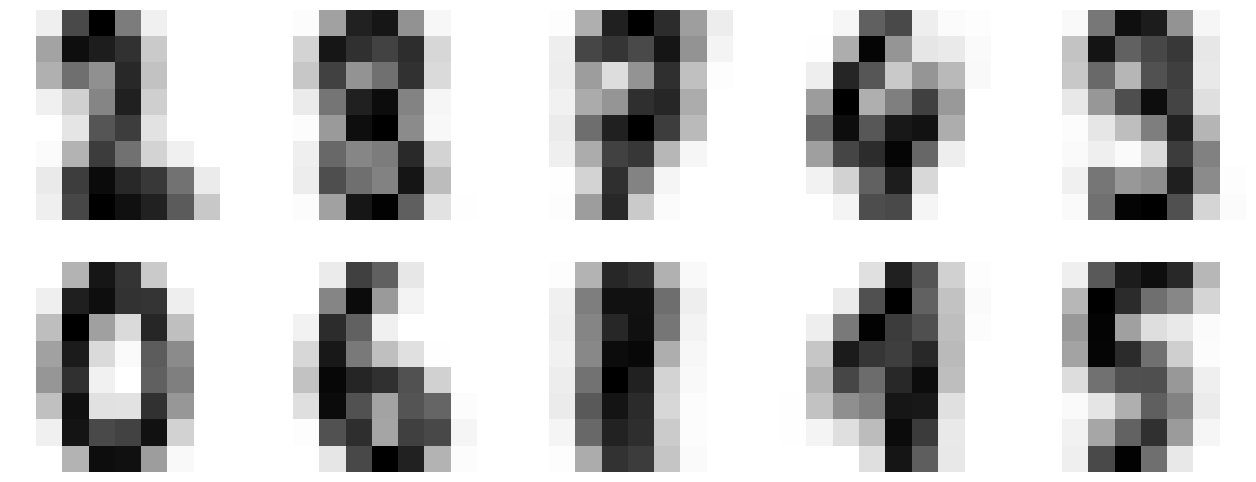

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for ax, center in zip(axes.flat, centers, strict=True):
    ax.imshow(center, cmap="binary")
    ax.axis("off")

These are *not* images of the digits from the dataset, there are cluster centers.
Some of them look similar to known digits, others are harder to tell.
I will argue that $0$ and $6$ are very visible in this case,
we will see whether it translates to the evaluation later.
Note that k-means starts from random centers,
if you run this code yourself several times you will get different
outputs but the cluster centers will look similar enough.

Remember that `kmeans` was never told what labels these digits,
it can only know that it should look for $10$ different digits in the data.
Hence, in order in which we plotted the centers,
k-means calls these clusters $0$, $1$, $2$, and so on.
Whenever the cluster index align with the actual digit in the cluster is out of pure luck.

In [5]:
clusters.shape, np.unique(clusters)

((1797,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32))

The default k-means scoring is by **cluster inertia**,
the sum of all distances form points to its cluster center.
Where the higher the sum is the worse is the clustering.
This allows to compare two k-means runs against each other.
Notably, `sklearn` initializes k-means several times and then compares the inertia.

But cluster inertia is not a good measure to compare
k-means between datasets or against other models.
Cluster inertia and other similar techniques (e.g. within cluster sum of squares)
perform certain assumption about cluster shape
and evaluate whether the resulting clusters follow that shape.
The strongest assumption is that all clusters are round,
i.e. have the same shape in every direction/dimension.
In `sklearn` the inertia sum score is negated (made negative)
so that the highest value is can achieve is zero,
the perfect inertia score.
This done by `sklearn` to such measures that are considered
to be worse as they increase,
it is made for consistency with positive scores.

Comparing unsupervised algorithms between themselves is always a tricky area.
Here we know the labels, therefore we can use better scoring techniques.

In [6]:
(
    metrics.v_measure_score(digits.target, clusters),
    metrics.adjusted_mutual_info_score(digits.target, clusters),
)

(0.7179473152727751, 0.7150988692724994)

Both the **v-measure** and **mutual information** are scoring techniques that
require the knowledge of the labels.
Yet, they work differently from F1 or accuracy scores.
For example if we have a $3$ class dataset: ships, cars and planes and:

- All cars are clustered together as planes,
- all ships are clustered together as cars,
- and all planes are clustered together as ships.

The we have a perfect ($1.0$) score.
In other words the scoring ignores the values of the labels,
it only checks whether the labels are together in the same cluster.

For an algorithm that only knew that there are $10$ digits in the data but had
no idea how they look like that is a pretty amazing score.
Let's look at what got misclassified the most.

A classification report would not give us a good visualization
because it assumes that the same labels are classified as themselves.
Instead we will build a confusion matrix,
which gives us what labels were assigned to each set of other labels.
We can then evaluate which classes the model is better at identifying,
even without knowing which class should be identified as what.

Note that we cannot give accurate ticks (labels) to the predicted values,
we can only guess their value from the ticks on the data we know.
The `confusion_matrix` procedure produces the matrix with the true labels,
first arguments, as rows and the predicted labels, second argument,
as the columns of the matrix.
This order of arguments and matrix order is important to remember,
it is easy to confuse oneself as to which are the true and which
the predicted labels and end with a transposed matrix.
That said, this order of matrix presentation is specific to `sklearn`,
a confusion matrix produced by other libraries may
produce a transposed version of the matrix.

array([[  0,   0,   0,   1,   0, 177,   0,   0,   0,   0],
       [ 25,   0,   0,   0,   0,   0,   2,  98,  56,   1],
       [147,   8,   2,   0,  11,   1,   0,   4,   4,   0],
       [  1,  22,   9,   0, 145,   0,   0,   4,   0,   2],
       [  0,   0,   3, 126,   0,   1,   0,   5,  45,   1],
       [  0,   0,   0,   1,  34,   0,   2,   0,   0, 145],
       [  0,   0,   0,   0,   0,   1, 176,   2,   2,   0],
       [  0,   0, 165,   0,   0,   0,   0,  14,   0,   0],
       [  2, 109,   4,   0,   1,   0,   1,  48,   3,   6],
       [  0,   7,   7,   0, 139,   0,   0,   1,  20,   6]])

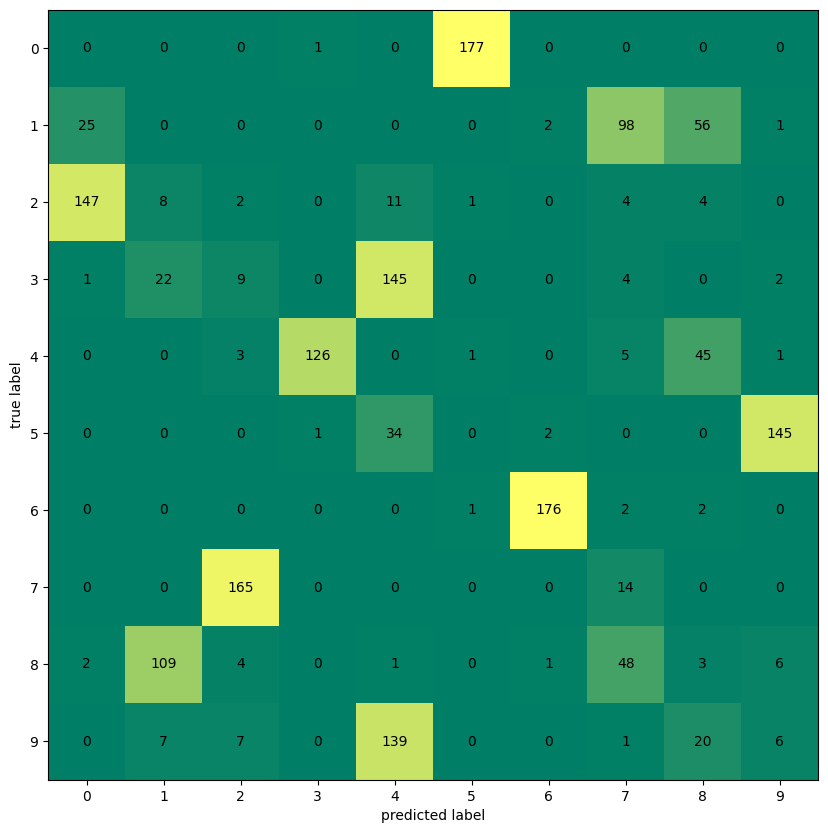

In [7]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(digits.target, clusters)
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(mat, cmap="summer")
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
ax.set_ylabel("true label")
ax.set_xlabel("predicted label")
ax.xaxis.set_ticks_position("bottom")

for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        ax.text(j, i, mat[i, j], ha="center", va="center")
mat

The `matshow` procedure works in the same way as `imshow`,
give a matrix it colors the values a pixels (or squares).
Note that showing images, or matrices in this case,
reverses the vertical axis.
The numbers on the vertical increase as they go downwards,
this is contrary to normal plots.
And thanks to this reversing of the vertical axis
we needed to force the tick position (`set_ticks_position`)
on the horizontal axis.

As we noted before, every k-means run will produce a different
matrix but the general patterns will be similar.
In the specific case here we can argue that (first row)
almost all zeros were assigned to the same cluster - cluster $1$.
The ones are rather varied but most of them have been assigned
to cluster $5$.
And a similar analysis can be made for every row.

Earlier we said that we have very good cluster centers for $0$ and $6$.
And this is indeed true row $0$ and row $6$ - assigned to clusters
$1$ and $7$ are almost all assigned to the same cluster each.

Often a confusion matrix is seen in the context of supervised learning,
and eventually we will see one in this context.
In supervised learning one argues that the main diagonal,
form the top left to the bottom right should hold the biggest values.
Here in unsupervised learning we do not know what the labels
on the horizontal axis should be,
hence that argument is not appropriate.

Since we can assign the cluster centers any names we like
we can move the columns of this matrix freely,
and doing that we could achieve the majority of the big numbers
in the main diagonal.
But that is beyond the point of the confusion matrix,
we use the matrix to check whether the clusters pick mostly the same digit.
In other words, we are checking whether we have one big number
per row and then just a few numbers that are not zero.
A perfect clustering evaluation would have just a single
number per column and per row.
Whether such a perfect classification would work on new,
previously unseen data, is a hard problem.
But one can reasonably say that a good enough clustering
would produce good enough generalization results.

Now, given new data we can ask our k-means model in which cluster it lives.
The model will tell us the label of the cluster,
we then can look into the confusion matrix and say what that label
maps to according to the true labels.
For example, given a new image to which our k-means predicts $9$
we can be rather confident that the image is of a $7$.
This may be a lot of trouble to go through for a prediction that
could be made directly with supervised learning
but one must remember that k-means would still work if we had
no labels at all or just a small handful of labels in our dataset.
Contrary to a supervised learning algorithm.

# References

[SciKit Learn - k-Means on Handwritten Digits][1]

[1]: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html